In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [13]:
# dataset paths
data_train_path = './train_folder'
data_test_path = './test_folder'

# Classes
classes = os.listdir(data_train_path)
num_classes = len(classes)

print("Total number of classes: " + str(num_classes))

Total number of classes: 2


In [ ]:
counts = []

for n_class in classes:
    class_path = os.path.join(data_train_path, n_class)
    count = len(os.listdir(class_path))
    counts.append((n_class, count))

counts = pd.DataFrame(counts, columns=['Class Name', 'Counts'])

counts = counts.sort_values(by='Counts', ascending=False)

plt.figure(figsize=(15, 10))
plt.barh(counts['Class Name'], counts['Counts'], color='skyblue')
plt.xlabel('Counts', fontsize=14)
plt.ylabel('Class Name', fontsize=14)
plt.title('Counts of Each Class', fontsize=20, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i in range(len(classes)):
    class_name = classes[i]
    class_path = os.path.join(data_train_path, class_name)
    
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    img_path = os.path.join(class_path, img_files[0])
    
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    row = i // 3
    col = i % 3

    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    ax[row, col].set_title(class_name)

plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SIZE=IMAGE_SIZE[0]

# Load the full training dataset (will be split later)
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# Preprocessing and performance optimization
full_train_ds = full_train_ds.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Count total number of batches
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
train_batches = int(0.9 * total_batches)
val_batches = total_batches - train_batches

# Split the dataset: 90% for training, 10% for validation
train_ds = full_train_ds.take(train_batches)
valid_ds = full_train_ds.skip(train_batches)

# Load the test dataset (from a separate folder)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print("Total batches:", total_batches+tf.data.experimental.cardinality(test_ds).numpy())
print("Train batches:", train_batches)
print("Validation batches:", val_batches)
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Found 1104 files belonging to 2 classes.
Found 301 files belonging to 2 classes.
Total batches: 45
Train batches: 31
Validation batches: 4
Test batches: 10


In [15]:
model = Sequential([
    layers.Conv2D(6, kernel_size=5, strides=1, activation='tanh', input_shape=(SIZE, SIZE, 3), padding='valid'),  # output: 28x28x6

    layers.AveragePooling2D(pool_size=2, strides=2),  # output: 14x14x6

    layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'),  # output: 10x10x16

    layers.AveragePooling2D(pool_size=2, strides=2),  # output: 5x5x16

    layers.Conv2D(120, kernel_size=5, strides=1, activation='tanh'),  # output: 1x1x120

    layers.Flatten(),

    layers.Dense(84, activation='tanh'),

    layers.Dense(num_classes, activation='softmax')
])


c:\Users\joaov\Desktop\programing\piton\TAA\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()

In [17]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=50,                                        # Number of epochs to train
    validation_data=valid_ds                          # Validation dataset
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 436ms/step - accuracy: 0.5227 - loss: 3.2060 - val_accuracy: 0.5859 - val_loss: 0.6824
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.5803 - loss: 0.6895 - val_accuracy: 0.5547 - val_loss: 0.6889
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 391ms/step - accuracy: 0.5698 - loss: 0.6824 - val_accuracy: 0.4766 - val_loss: 0.6960
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 422ms/step - accuracy: 0.5167 - loss: 0.6923 - val_accuracy: 0.5703 - val_loss: 0.6854
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 382ms/step - accuracy: 0.5076 - loss: 0.6937 - val_accuracy: 0.5391 - val_loss: 0.6875
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - accuracy: 0.5066 - loss: 0.6934 - val_accuracy: 0.5089 - val_loss: 0.6936
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 432ms/step - accuracy: 0.5218 - loss: 0.6885 - val_accuracy: 0.5391 - val_loss: 0.6850
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.5833 - loss: 0.6831 - val_accu

In [18]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

,accuracy,loss,val_accuracy,val_loss
45,0.835041,0.388779,0.882812,0.356294
46,0.891393,0.333757,0.866071,0.338006
47,0.876025,0.324765,0.906250,0.238623
48,0.930328,0.235507,0.984375,0.157214
49,0.962090,0.168338,0.984375,0.116634


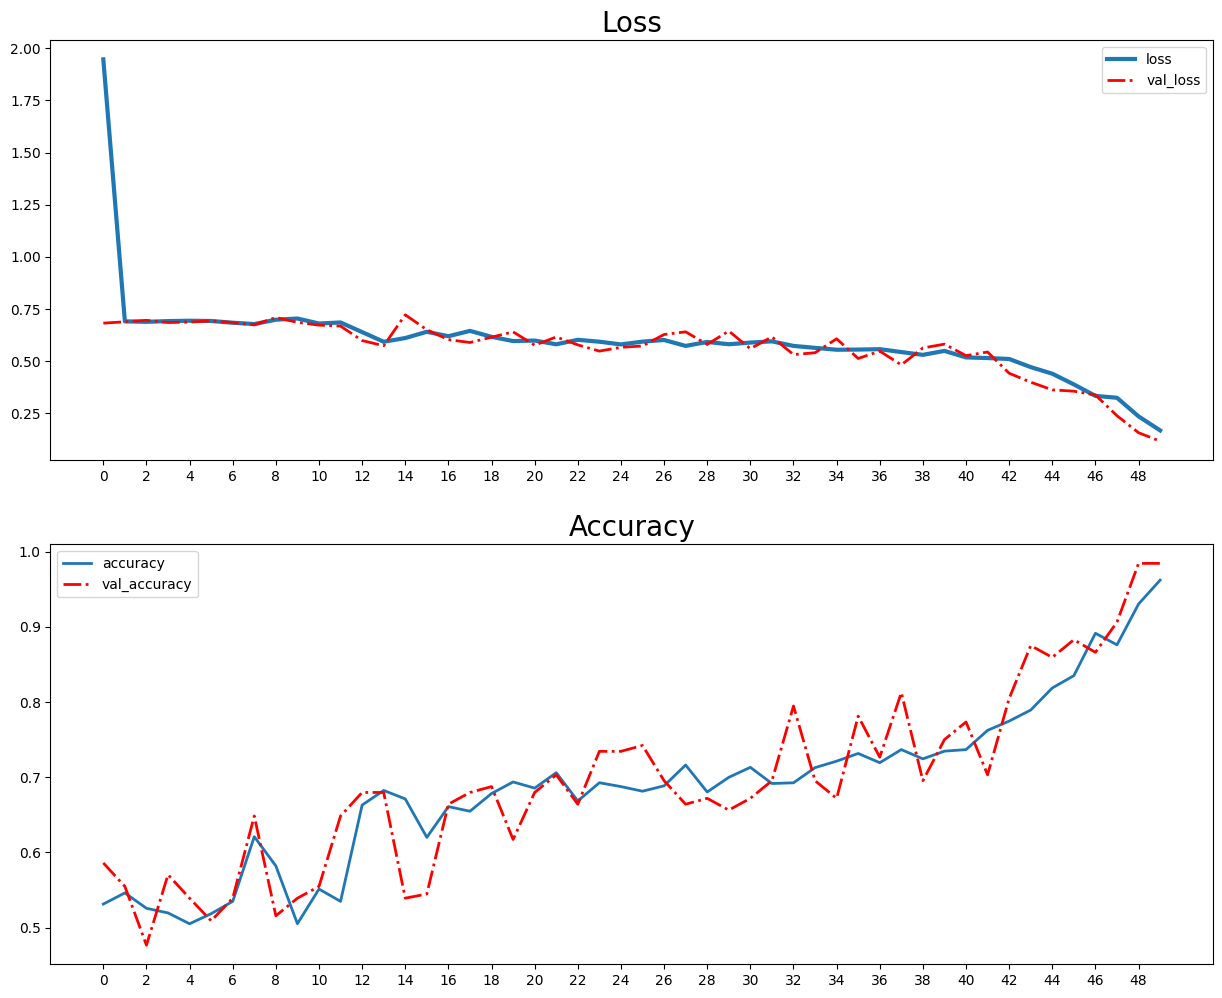

In [19]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

# #  AX2 : Loss
# ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
# ax[2].set_title('learning_rate', fontsize=20)
# ax[2].set_xlabel('epochs')
# ax[2].set_xticks(np.arange(0, len(x), 2))
# ax[2].legend()

plt.show()

In [20]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
# best_model = tf.keras.models.load_model('MyModel.keras')

In [ ]:
# # Evaluate model by model.evaluate()
# loss, accuracy = model.evaluate(test_ds)
# print()
# print(f'Loss : {loss}')
# print(f'Accuracy : {accuracy*100}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test Loss       : {loss:.4f}')
print(f'Test Accuracy   : {accuracy * 100:.2f}%')

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute additional metrics
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Print all metrics
print()
print("Additional Evaluation Metrics:")
print(f"Macro Precision : {precision_macro:.4f}")
print(f"Macro Recall    : {recall_macro:.4f}")
print(f"Macro F1 Score  : {f1_macro:.4f}")
print(f"Micro F1 Score  : {f1_micro:.4f}")
print(f"Weighted F1     : {f1_weighted:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.8053 - loss: 0.4412

Loss : 0.49061504006385803
Accuracy : 80.06644248962402%


In [ ]:
# Confusion Matrix

# Get predictions and true labels from the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = classes  # use the already defined list of class names

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

In [ ]:
images_per_class = 2
total_images = len(classes) * images_per_class
rows = (total_images + 2) // 3

fig, ax = plt.subplots(rows, 3, figsize=(12, 4 * rows))

for i, class_name in enumerate(classes):
    class_path = os.path.join(data_test_path, class_name)
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    for j in range(images_per_class):
        idx = i * images_per_class + j
        if idx >= total_images or j >= len(img_files):
            continue  

        img_path = os.path.join(class_path, img_files[j])
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Resize and normalize the image for the model
        img_resized = cv.resize(img_rgb, IMAGE_SIZE)
        input_img = normalization_layer(tf.convert_to_tensor(img_resized[np.newaxis, ...], dtype=tf.float32))[0].numpy()
        input_tensor = np.expand_dims(input_img, axis=0)

        prediction = model.predict(input_tensor)
        pred_class = tf.argmax(prediction, axis=1).numpy()[0]

        row = idx // 3
        col = idx % 3

        ax[row, col].imshow(img_rgb)
        ax[row, col].axis('off')
        ax[row, col].set_title(f"Real: {class_name}\nGuess: {classes[pred_class]}", fontsize=10)

plt.tight_layout()
plt.show()
